In [192]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools

from dataclasses import dataclass

In [193]:
# READ BENCHMARK DATA


@dataclass(frozen=True)
class Message:
    client: int
    message: int
    timestamp: float
    duration: float


@dataclass(frozen=True)
class Benchmark:
    clients: int
    difficulty: int
    runtime: int
    prepared: int
    acceptance_window: int
    messages: Message

    @functools.cached_property
    def avg_duration(self):
        return np.mean([m.duration for m in self.messages])

    @functools.cached_property
    def min_duration(self):
        return np.min([m.duration for m in self.messages])

    @functools.cached_property
    def max_duration(self):
        return np.max([m.duration for m in self.messages])

    @functools.cached_property
    def min_timestamp(self):
        return np.min([m.timestamp for m in self.messages])

    @functools.cached_property
    def max_timestamp(self):
        return np.max([m.timestamp for m in self.messages])

    @functools.cached_property
    def total_runtime(self):
        return self.max_timestamp - self.min_timestamp

    @functools.cached_property
    def throughput(self):
        return len(self.messages) / self.total_runtime


def read_benchmark(path: str) -> Benchmark:
    with open(path, "r") as f:
        d = json.load(f)
        messages = [Message(**m) for m in d["messages"]]
        return Benchmark(
            clients=d["clients"],
            difficulty=d["difficulty"],
            runtime=d["runtime"],
            prepared=d["prepared"],
            acceptance_window=d["acceptance_window"],
            messages=messages,
        )


def read_benchmarks(dir: str) -> list[Benchmark]:
    benchmarks = [
        read_benchmark(os.path.join(dir, f))
        for f in os.listdir(dir)
        if f.endswith(".json")
    ]
    benchmarks_sorted = sorted(benchmarks, key=lambda x: (x.clients, x.difficulty))
    return benchmarks_sorted


benchmarks = read_benchmarks("../benchmark")

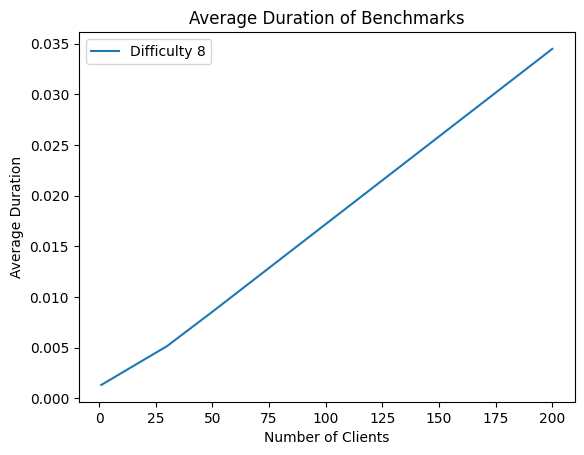

In [194]:
import matplotlib.pyplot as plt

# Extract the required data
clients = [benchmark.clients for benchmark in benchmarks]
difficulties = [benchmark.difficulty for benchmark in benchmarks]
avg_durations = [benchmark.avg_duration for benchmark in benchmarks]

# Create a dictionary to store the average durations for each difficulty
duration_dict = {}
for client, difficulty, avg_duration in zip(clients, difficulties, avg_durations):
    if difficulty not in duration_dict:
        duration_dict[difficulty] = {'clients': [], 'durations': []}
    duration_dict[difficulty]['clients'].append(client)
    duration_dict[difficulty]['durations'].append(avg_duration)

# Plot the average durations for each difficulty
for difficulty, data in duration_dict.items():
    plt.plot(data['clients'], data['durations'], label=f'Difficulty {difficulty}')

# Set the labels and title
plt.xlabel('Number of Clients')
plt.ylabel('Average Duration')
plt.title('Average Duration of Benchmarks')

# Add a legend
plt.legend()

# Show the plot
plt.show()

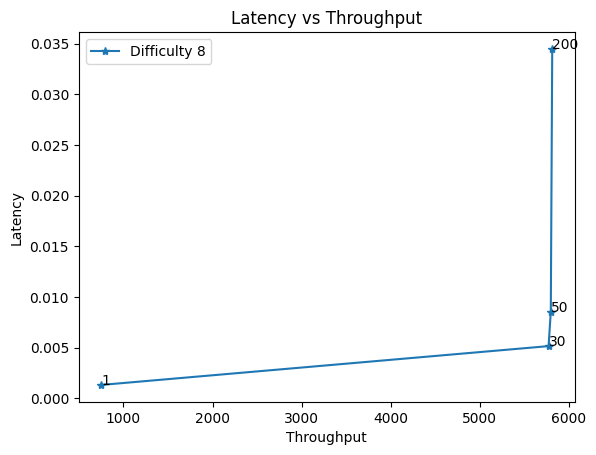

In [195]:
import matplotlib.pyplot as plt

# Extract the required data
latencies = [benchmark.avg_duration for benchmark in benchmarks]
throughputs = [benchmark.throughput for benchmark in benchmarks]
difficulties = [benchmark.difficulty for benchmark in benchmarks]
clients = [benchmark.clients for benchmark in benchmarks]

# Create a dictionary to store the latencies and throughputs for each difficulty
data_dict = {}
for latency, throughput, difficulty, client in zip(latencies, throughputs, difficulties, clients):
    if difficulty not in data_dict:
        data_dict[difficulty] = {'latencies': [], 'throughputs': [], 'clients': []}
    data_dict[difficulty]['latencies'].append(latency)
    data_dict[difficulty]['throughputs'].append(throughput)
    data_dict[difficulty]['clients'].append(client)

# Plot the latency/throughput graph for each difficulty
for difficulty, data in data_dict.items():
    plt.plot(data['throughputs'], data['latencies'], marker='*', label=f'Difficulty {difficulty}')
    for i, client in enumerate(data['clients']):
        plt.annotate(client, (data['throughputs'][i], data['latencies'][i]))

# Set the labels and title
plt.xlabel('Throughput')
plt.ylabel('Latency')
plt.title('Latency vs Throughput')

# Add a legend
plt.legend()

# Show the plot
plt.show()